# Global income distribution and the utility of money
    

Much effort is devoted to collecting statistics about the prosperity of countries, and the way that income is shared out amongst their populations. Gross domestic product (GDP) per capita, or mean household income, for example, both give some measurement of the overall amount of income amongst a population. However they both have the shortcoming that they do not take into account the distribution of that income. So, for example, Equatorial Guinea has a higher GDP per capita than Portugal, Hungary or Russia, but objectively far worse living standards. Other statistics focus on measuring inequality of wealth or income, for example Gini coefficients. These are also important, showing for example that inequality has steadily increased in almost every country in the world over past decades. However they don't help with assessing the tradeoff between overall income and inequality. If a country becomes richer overall but also more unequal, is the general population worse or better off?

A simple way to look at the overall economic wellbeing of a population is to consider the utility of money. The extent to which an amount of money (whether as income or wealth) is of benefit to someone is not linearly related to its face value. Bernoulli commented in 1738 that "there is no doubt that a gain of one thousand ducats is more significant to a pauper than to a rich man though both gain the same amount." In his work *Exposition of a New Theory on the Measurement of Risk*, he developed the concept of diminishing marginal utility of money, and in particular that the utility gained by receiving a certain amount of money is inversely proportional to how much one already has. We can think of the utility of a certain income as roughly logarithmic to its face value. Going from an income of \$1000 to \$2000 is roughly as much of an improvement in utility as going from \$1,000,000 to \$2,000,000.

Therefore, one way of measuring the overall economic wellbeing of a population in terms of income, if we knew the income $a_i$ of every individual $i$ in a population of $N$, would be the average *utility of income*:

\begin{equation}
U = \frac{1}{N} \sum_i log(a_i)\ .
\end{equation}

This could be rearranged in terms of every discrete income level $x$ as

\begin{equation}
U = \sum_x p(x) \log(x)\ ,
\end{equation}

where $p(x)$ is the proportion of the population with income level $x$. The form of this equation means that utility can be increased in two ways: either by increasing the total amount of income received in the population, or by distributing it more equally. For a fixed amount of total income, utility is maximised when it is evenly distributed. Hence this measure computes the benefits of income, accounting for both the levels of prosperity and of inequality.

We investigate this measure below and examine with available datasets what it tells us about the relative utility from income achieved by different countries at different times.

### Existing measures of overall economic wellbeing

There are some mainstream measures of economic wellbeing, which take into account both how much income is generated in a society as well as how it is spread out. The UN human development index includes as one factor the log of the mean household income, to reflect the diminishing marginal utility of money (http://hdr.undp.org/en/content/why-hdi-using-logarithm-income-component), though is done with only one income figure for a whole country. Median household income is another relevant measure which in effect shows middle class economic wellbeing (https://en.wikipedia.org/wiki/Median_income), though this does not take into account the shape of the income distribution.

In [1]:
import pandas as pd
import operator
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Read in the World Income Inequality Database. This contains, among other things, information about the share of income which each decile of the population received for a particular country and year.

In [2]:
df = pd.read_stata('data/WIID3.4_19JAN2017.dta')
df = df.loc[:,['Country','Countrycode3','Year',
           'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']]

For some country/years there are several entries, from different survey sources. Take a mean of the values here (though note this might create some problems, e.g. if different surveys are calibrated differently).

In [4]:
countryyear = pd.pivot_table(df,
               values=['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10'],
               index=['Country','Countrycode3','Year'],aggfunc=np.nanmean)

countryyear = countryyear.dropna()
countryyear = countryyear.reset_index()

/Users/jq/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:933: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)


Although the survey data in the WIID contains estimates of income, it can be difficult to use it to compare places and times because of different survey methods and calibration. So we use GDP per capita here as an estimate of mean income. This is not the same thing, but in practice is quite close. All figures converted to 2010 US$ for comparison across places and times.

In [5]:
gdp_per_cap = pd.read_csv('data/gdp_per_capita_2010_usd.csv', encoding='ISO-8859-1', index_col='Country Code')

def get_country_year_gdp(countrycode,year):
    try:
        return gdp_per_cap.loc[countrycode,'{:.0f}'.format(year)]
    except:
        return np.nan
    
countryyear['gdp_per_cap_2010$'] = countryyear.apply(lambda row: get_country_year_gdp(row['Countrycode3'],row['Year']),axis=1)

for decile in range(1,11):
    countryyear['D{}_meanusd'.format(decile)] = countryyear['gdp_per_cap_2010$']*countryyear['D{}'.format(decile)]/10

## Roughly estimate utility of income to compare countries and times

The problem with the utility of income formulation above is that to calculate it exactly would require knowledge of the income of every individual in a country. So in practice we have to make some assumptions about the distribution of income given the information available. The first thing we can try, since we have decile income share information, is a very simple assumption: that every individual in the same decile has exactly the same income. This is obviously wrong, but might start to give some idea of the relative utility of income between countries and times.

In [6]:
countryyear['utility_uniformdeciles'] = 0
for d in range(1,11):
    countryyear['utility_uniformdeciles'] += .1*np.log(countryyear['D{}_meanusd'.format(d)])

Visualise some of the changes in income share and utility for different countries

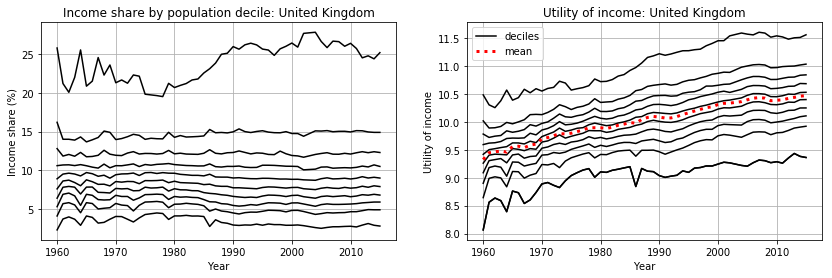

In [7]:
def plot_income_share_by_country_decile(country):
    years = np.array(countryyear.query('Country=="{}"'.format(country)).loc[:,'Year'])
    datacols = []
    for d in range(1,11):
        datacols.append('D{}'.format(d))
    X = np.array(countryyear.query('Country=="{}"'.format(country)).loc[:,datacols])
    plot(years,X,'k')
    xlabel('Year')
    ylabel('Income share (%)')
    title('Income share by population decile: {}'.format(country))
    grid()
    
def plot_utility_of_income_by_country_decile(country):
    years = np.array(countryyear.query('Country=="{}"'.format(country)).loc[:,'Year'])
    datacols = []
    for d in range(1,11):
        datacols.append('D{}_meanusd'.format(d))
    X = np.array(countryyear.query('Country=="{}"'.format(country)).loc[:,datacols])
    X_mean = np.array(countryyear.query('Country=="{}"'.format(country)).loc[:,'utility_uniformdeciles'])
    
    plot(years,np.log(X[:,0]),'k',label='deciles')
    plot(years,np.log(X),'k')
    plot(years,X_mean,'r:',lw=3,label='mean')
    legend()
    xlabel('Year')
    ylabel('Utility of income')
    title('Utility of income: {}'.format(country))
    grid()

country = "United Kingdom"
subplot(121)
plot_income_share_by_country_decile(country)
subplot(122)
plot_utility_of_income_by_country_decile(country)
gcf().set_size_inches(14,4)

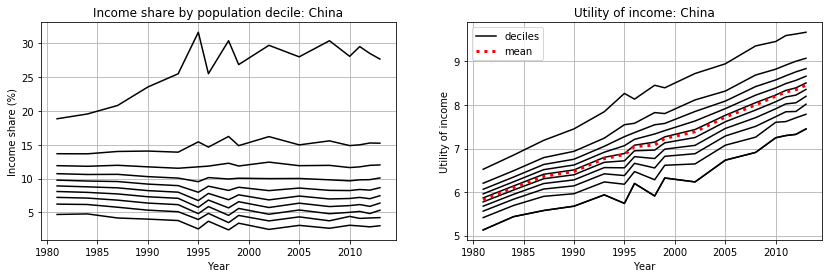

In [9]:
country = "China"
subplot(121)
plot_income_share_by_country_decile(country)
subplot(122)
plot_utility_of_income_by_country_decile(country)
gcf().set_size_inches(14,4)

Compare countries by looking at the GDP income for 2016 and the most recently available income share distribution. How does the ranking of countries change when looking at mean income vs utility of income?

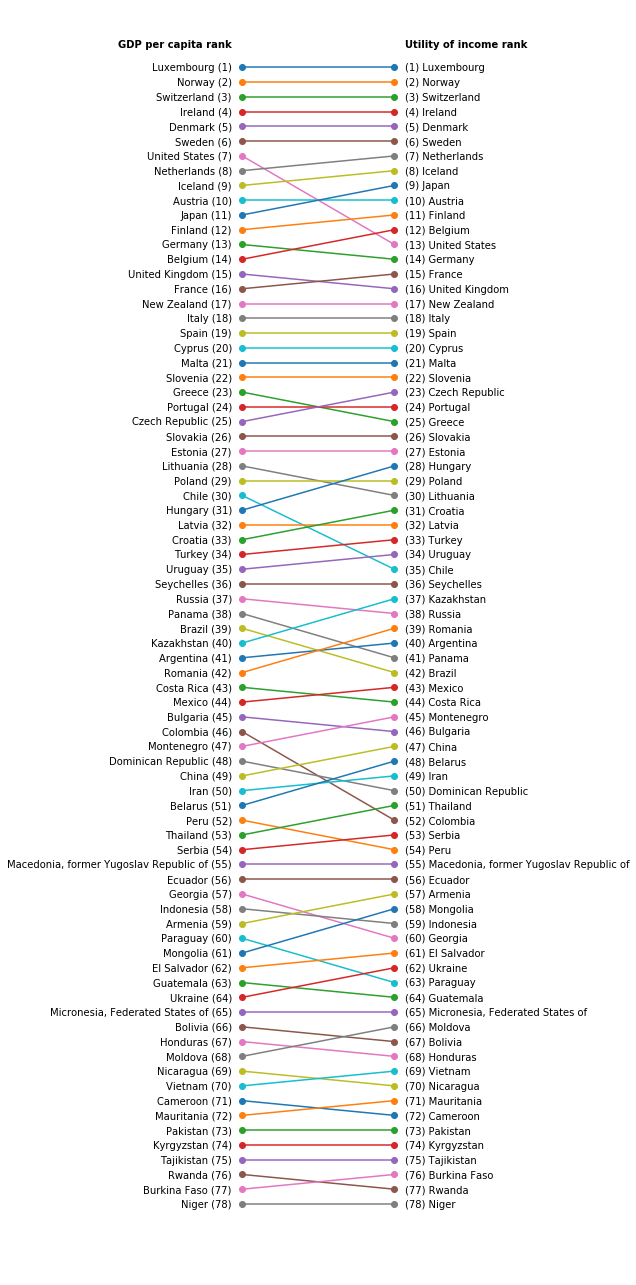

In [10]:
countries = countryyear.Country.unique()
country_utility2016 = {}
country_gdp2016 = {}
for c in countries:
    cdf = countryyear.query('Country=="{}"'.format(c))
    row = cdf.sort_values(by='Year').iloc[-1,:]
    if row['Year']>2012:
        gdp = get_country_year_gdp(row['Countrycode3'],2016)
        if not isnan(gdp):
            cols = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']
            utility = 0
            for d in range(1,11):
                utility += .1*np.log(row['D{}'.format(d)]*gdp)
            if not isnan(utility):
                country_gdp2016[c] = gdp
                country_utility2016[c] = utility

sorted_gdp = sorted(country_gdp2016.items(), key=operator.itemgetter(1))[::-1]
sorted_utility = sorted(country_utility2016.items(), key=operator.itemgetter(1))[::-1]

ranked_gdp = {}
ranked_utility = {}
for i in range(len(sorted_gdp)):
    ranked_gdp[sorted_gdp[i][0]] = i+1
    ranked_utility[sorted_utility[i][0]] = i+1

countryranks = []
for c in ranked_gdp.keys():
    countryranks.append({'country':c,
                         'gdp_rank':ranked_gdp[c],
                         'utility_rank':ranked_utility[c]})
    
for c in ranked_gdp.keys():
    text(1,-.025-ranked_gdp[c]*.1,
         '{} ({})'.format(c,ranked_gdp[c]),
         horizontalalignment='right')
    text(1.5,-.025-ranked_utility[c]*.1,
         '({}) {}'.format(ranked_utility[c],c),
         horizontalalignment='left')
    plot([1.03,1.47],[-ranked_gdp[c]*.1,-ranked_utility[c]*.1],marker='o')

text(1,.03,'GDP per capita rank',horizontalalignment='right',weight='bold')
text(1.5,.03,'Utility of income rank',horizontalalignment='left',weight='bold')

box(False)
axis('off')
gcf().set_size_inches(3,23)  

This already shows some interesting changes to the picture of economic wellbeing given by GDP per capita. In particular, the United States is lower ranked by 6 places in terms of utility given its inequitable income distribution, with similar effects for LatAm countries including Chile and Colombia.

However... recalling that we are using a crude assumption to calculate utility of income -- that all members of the population within a certain decile have the same income -- these calculations so far understate the differences to utility caused by inequality. Our assumption makes it seem that the income distribution is flatter than it really is. In fact, within each decile there is also wide variability of income. For example, within the United States there is evidence to suggest that the top 1% of earners receive 22% of the income share (https://eml.berkeley.edu/~saez/saez-UStopincomes-2015.pdf).

The innacuracies are greatest at the upper and lower tails of the income distribution.

## Fit a Pareto distribution to upper deciles income share

Pareto distributions are sometimes used to make estimates about the high tails of income distribution where explicit data is not available. So we can try to do parameter fitting with Pareto given the information available to use for each country/year and see what it tells us about the upper tail.

The parameter fitting here is different to the normal case because we only have information about the share in each decile. So overall our strategy is to compute, for particular values of $x_0$ and $\alpha$, what the average income for each decile of the population would be, and then choose the parameter settings which give the closest agreement to the data.

First we need to calculate the PPP\$ cutoffs for each of the deciles: i.e. what is the income threshold that separates the lowest 10% from the rest, and so on. These cutoff values $\left\{t_0,\ldots,t_9\right\}$ can be computed using the Pareto inverse CDF as:

\begin{equation}
t_i = \frac{x_0}{\left(1-\frac{i}{10}\right)^{\frac{1}{\alpha}}} \ . \\
\end{equation}

Given this we can find the expected income for the $i$th decile, $\bar{I}_i$, by taking expectation of the PDF:

\begin{eqnarray*}
\bar{I}_i & = & \int_{t_{i-1}}^{t_i} x p(x\ |\ x_0,\alpha)\ dx \\
& = & \int_{t_{i-1}}^{t_i} x \frac{\alpha\,x_0^\alpha}{x^{\alpha+1}} dx \\
& = & \int_{t_{i-1}}^{t_i} \frac{\alpha\,x_0^\alpha}{x^{\alpha}} dx \\
& = & \left[ \frac{\alpha x^{1-\alpha} x_0^\alpha}{1-\alpha} \right]^{t_i}_{t_{i-1}}\ .
\end{eqnarray*}

(Note that for the top decile, we have to use the indefinite integral since $t_{10}$ is infinite.)

We can then look at how well the expected mean income for each decile compares with the reported data. This allows us to carry out a grid search on many settings of $\left\{x_0, \alpha\right\}$, and choose the best according to a minimum least squares criteria.

In [11]:
def pareto_inverse_cdf(F,x_0,alpha):
    return x_0/((1-F)**alpha)

def decile_income_thresholds(x_0,alpha):
    thresholds = []
    for i in range(10):
        t = x_0 / (1-.1*i)**(1/alpha)
        thresholds.append(t)
    return np.array(thresholds)

def mean_income_in_deciles(x_0,alpha):
    t = decile_income_thresholds(x_0,alpha)
    integrals = []
    for i in range(1,10):
        integral_i = alpha*( ((t[i-1]**(1-alpha))/(alpha-1)) - ((t[i]**(1-alpha))/(alpha-1)) )*(x_0**alpha)
        
        # We normalise by the area under the PDF between the limits
        # (though in this case we know it's always .1 because we're dealing with deciles)
        #denominator_i = (t[i]**alpha - t[i-1]**alpha)*(x_0**alpha)/((t[i-1]**alpha) * (t[i]**alpha))
        denominator_i = .1
        
        integrals.append(integral_i/denominator_i)
        
    # The last value has to be treated differently, since the upper limit is infinity
    integral_10 = alpha*(t[9]**(1-alpha))*(x_0**alpha)/(alpha-1)
    #denominator_10 = (x_0**alpha)/(t[9]**alpha)
    denominator_10 = .1
    
    integrals.append(integral_10/denominator_10)
    
    return np.array(integrals)

def score_parameters(deciles,x_0,alpha,num_upper_deciles_to_fit):
    deciles_predicted = mean_income_in_deciles(x_0,alpha)
    return np.sum((np.log(deciles_predicted[-num_upper_deciles_to_fit:]) - np.log(deciles[-num_upper_deciles_to_fit:]))**2)

def fit_pareto(deciles,alpha_range=[1.01,5],
               x_0_range=[.1,.9],
               n_candidates=100,
               num_upper_deciles_to_fit=4):
    # Choose parameter candidates uniformly on a log scale
    alpha_candidates = np.logspace(log10(alpha_range[0]),
                                   log10(alpha_range[1]),
                                   n_candidates)
    
    # Note that x_0 should be lower than the lowest decile value
    x_0_candidates = np.logspace(log10(deciles[-num_upper_deciles_to_fit-1]*x_0_range[0]),
                                 log10(deciles[-num_upper_deciles_to_fit-1]*x_0_range[1]),
                                 n_candidates)
        
    lowest_score = np.inf
    alpha_best = np.nan
    x_0_best = np.nan
    
    for alpha in alpha_candidates:
        for x_0 in x_0_candidates:
            try:
                score = score_parameters(deciles,x_0,alpha,num_upper_deciles_to_fit)
                
                if score<lowest_score:
                    lowest_score = score
                    alpha_best = alpha
                    x_0_best = x_0
            except Exception as e:
                print('error',x_0,alpha)
                raise e
                
    return x_0_best,alpha_best

Assess the fit on a random country/year

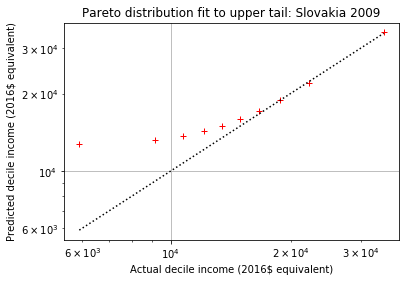

In [13]:
idx = np.random.permutation(list(countryyear.index))[0]

country = countryyear.Country[idx]
countrycode = countryyear.Countrycode3[idx]
year = countryyear.Year[idx]

deciles = countryyear.loc[idx,['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']].values/10
deciles = deciles * get_country_year_gdp(countrycode,year)
deciles = deciles.astype('float64')

x_0,alpha = fit_pareto(deciles, num_upper_deciles_to_fit=4)

deciles_predicted = mean_income_in_deciles(x_0,alpha)

minmax = (min(deciles),max(deciles))
plot(deciles,deciles_predicted,'r+')
loglog(minmax,minmax,'k:')
title('Pareto distribution fit to upper tail: {} {}'.format(country,int(year)))
xlabel('Actual decile income (2016$ equivalent)')
ylabel('Predicted decile income (2016$ equivalent)')
grid()

Next, get a better model for the whole income distribution and recalculate utility of income.